In [15]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os 
import random
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

In [16]:
data_trans=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [17]:
train_data = datasets.CIFAR10(root='/Users/13173203690/Desktop/PyTorch/data', train=True, 
                                        download=True, transform=data_trans)
test_data = datasets.CIFAR10(root='/Users/13173203690/Desktop/PyTorch/data', train=True, 
                                        download=True, transform=data_trans)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_data.data.shape

(50000, 32, 32, 3)

In [19]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])
print(len(train_data),len(valid_data),len(test_data))

45000 5000 50000


In [20]:
batch_size=100
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        
        self.fc1=nn.Linear(16*5*5,120)
        
        self.fc2=nn.Linear(120,80)
        
        self.fc3=nn.Linear(80,10)#不用增加softmax层，在cross_entropy的Loss中自动增加了Softmax
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(x.shape[0],-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [6]:
class VGGNet11(nn.Module):
    def __init__(self):
        super(VGGNet11,self).__init__()
        self.feature=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#16*16
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#8*8
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#4*4
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#2*2
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#1*1
        )
        self.classifier=nn.Linear(512,10)
        
    def forward(self,x):
        x=self.feature(x)
        x=x.view(x.shape[0],-1)
        x=self.classifier(x)
        return x

In [21]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResNetBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)#ResNet的add操作，其实是张量的加和
        out = F.relu(out)
        return out

class ResNetLayer(nn.Module):
    def __init__(self,n_blocks,in_channels,out_channels,stride):
        super(ResNetLayer,self).__init__()
        self.modules=[]
        self.modules.append(ResNetBlock(in_channels,out_channels,stride))
        for _ in range(n_blocks-1):
            self.modules.append(ResNetBlock(out_channels,out_channels,1))
        self.blocks=nn.Sequential(*self.modules)
        
    def forward(self,x):
        return self.blocks(x)
    
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18,self).__init__()
        n_blocks=[2,2,2,2]
        self.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.rb1=ResNetLayer(n_blocks[0],64,64,1)
        self.rb2=ResNetLayer(n_blocks[1],64,128,2)
        self.rb3=ResNetLayer(n_blocks[2],128,256,2)
        self.rb4=ResNetLayer(n_blocks[3],256,512,2)
        self.fc=nn.Linear(512,10)
        
    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.rb1(out)
        out=self.rb2(out)
        out=self.rb3(out)
        out=self.rb4(out)
        out=F.avg_pool2d(out,4)
        out=out.view(out.shape[0],-1)
        out=self.fc(out)
        return out
        
#ResNet34->[3,4,6,3]


In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
model_dir='models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [13]:
model1=LeNet().to(device)
model_path1=os.path.join(model_dir,'lenet_c10.pt')
optimizer1=optim.Adam(model1.parameters())
criterion=nn.CrossEntropyLoss()

In [8]:
model2=VGGNet11().to(device)
model_path2=os.path.join(model_dir,'vgg11_c10.pt')
optimizer2=optim.Adam(model2.parameters())
criterion=nn.CrossEntropyLoss()

In [22]:
model3=ResNet18().to(device)
model_path3=os.path.join(model_dir,'resnet18_c10.pt')
optimizer3=optim.Adam(model3.parameters())
criterion=nn.CrossEntropyLoss()

In [24]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

In [25]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [27]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## leNet开始训练

In [14]:
epochs=30
best_valid_loss=float('inf')

In [15]:
#LeNet网络训练结果如下：
print("LeNet网络训练结果如下:")
for epoch in range(epochs):
    train_loss,train_acc=train(model1,device,train_iterator,optimizer1,criterion)
    valid_loss,valid_acc=evaluate(model1,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model1.state_dict(),model_path1)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

LeNet网络训练结果如下:
Epoch:1|Train Loss:1.7598242984877692|Train Acc:0.3465777692447106|Val Loss:1.5636554837226868|Val Acc:0.4229999876022339
Epoch:2|Train Loss:1.51264749262068|Train Acc:0.4462888769308726|Val Loss:1.465416703224182|Val Acc:0.45939998745918276
Epoch:3|Train Loss:1.4187869540850322|Train Acc:0.4856222090456221|Val Loss:1.3708262538909912|Val Acc:0.5031999868154525
Epoch:4|Train Loss:1.3582161106003656|Train Acc:0.5103333197037379|Val Loss:1.3292373466491698|Val Acc:0.513199987411499
Epoch:5|Train Loss:1.3080612601174249|Train Acc:0.5316666544146008|Val Loss:1.2650263500213623|Val Acc:0.541399992108345
Epoch:6|Train Loss:1.2742042251427967|Train Acc:0.5431999864843157|Val Loss:1.2634567308425904|Val Acc:0.5405999857187271
Epoch:7|Train Loss:1.248530060450236|Train Acc:0.5547110996643703|Val Loss:1.2426245856285094|Val Acc:0.5503999918699265
Epoch:8|Train Loss:1.2196088671684264|Train Acc:0.5654666537708707|Val Loss:1.2076925396919251|Val Acc:0.568199987411499
Epoch:9|Train L

In [16]:
model1.load_state_dict(torch.load(model_path1))

test_loss, test_acc = evaluate(model1, device, test_iterator, criterion)
print("LeNet测试集分类结果如下:")
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

LeNet测试集分类结果如下:
| Test Loss: 0.9988894089460373 | Test Acc: 0.6453399854302406 |


# VGG11开始训练

In [14]:
epochs=30
best_valid_loss=float('inf')
#googlenet网络训练结果如下：
print("VGG11网络训练结果如下:")
for epoch in range(epochs):
    train_loss,train_acc=train(model2,device,train_iterator,optimizer2,criterion)
    valid_loss,valid_acc=evaluate(model2,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model2.state_dict(),model_path2)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

VGG11网络训练结果如下:
Epoch:1|Train Loss:1.0210551606284248|Train Acc:0.6339110966523488|Val Loss:0.9138355433940888|Val Acc:0.672599984407425
Epoch:2|Train Loss:0.8447217306825849|Train Acc:0.7050888726446364|Val Loss:0.8516418719291687|Val Acc:0.7083999824523926
Epoch:3|Train Loss:0.7389052988423241|Train Acc:0.7419999828603533|Val Loss:0.7114119559526444|Val Acc:0.7475999820232392
Epoch:4|Train Loss:0.6652127528852887|Train Acc:0.7707110918892754|Val Loss:0.6811212831735611|Val Acc:0.7633999812602997
Epoch:5|Train Loss:0.6130393642187119|Train Acc:0.7890222007698483|Val Loss:0.6376495307683945|Val Acc:0.7795999801158905
Epoch:6|Train Loss:0.5581505809227626|Train Acc:0.8075110887156592|Val Loss:0.639107386469841|Val Acc:0.7775999820232391
Epoch:7|Train Loss:0.5244511289729012|Train Acc:0.8187555348873139|Val Loss:0.6622011590003968|Val Acc:0.7733999800682068
Epoch:8|Train Loss:0.4939105029569732|Train Acc:0.8295999789237976|Val Loss:0.6257929569482803|Val Acc:0.7911999797821045
Epoch:9|Tra

# ResNet18开始训练

In [28]:
epochs=30
best_valid_loss=float('inf')
#googlenet网络训练结果如下：
print("ResNet18网络训练结果如下:")
for epoch in range(epochs):
    train_loss,train_acc=train(model3,device,train_iterator,optimizer3,criterion)
    valid_loss,valid_acc=evaluate(model3,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model3.state_dict(),model_path3)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

ResNet18网络训练结果如下:
Epoch:1|Train Loss:1.0512390630775028|Train Acc:0.6256222082508935|Val Loss:1.1295244324207305|Val Acc:0.6071999841928482
Epoch:2|Train Loss:0.8657605954011282|Train Acc:0.6934666506449382|Val Loss:0.858812757730484|Val Acc:0.6971999824047088
Epoch:3|Train Loss:0.7283431863784791|Train Acc:0.7438444271352556|Val Loss:0.8090632295608521|Val Acc:0.7227999889850616
Epoch:4|Train Loss:0.633643795185619|Train Acc:0.7782666480541229|Val Loss:0.6606084078550338|Val Acc:0.7711999797821045
Epoch:5|Train Loss:0.5605006755722893|Train Acc:0.8033555364608764|Val Loss:0.6264636135101318|Val Acc:0.7937999773025513
Epoch:6|Train Loss:0.5162947726911968|Train Acc:0.8217555349402957|Val Loss:0.5471976399421692|Val Acc:0.8095999801158905
Epoch:7|Train Loss:0.46939892407920625|Train Acc:0.8360666451189253|Val Loss:0.5257291877269745|Val Acc:0.8153999769687652
Epoch:8|Train Loss:0.4326135430071089|Train Acc:0.8495999795860715|Val Loss:0.4828789556026459|Val Acc:0.8333999752998352
Epoch:9

## 模型评测

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [31]:
def evaluate2(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    prediction=[]
    groundtruth=[]
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            prediction.append(fx)
            groundtruth.append(y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator),prediction,groundtruth

In [32]:
def model_merics(prediction,groundtruth):#模型评测函数，画ROC和PR曲线
    pred=torch.cat(prediction).cpu().numpy()
    gt=torch.cat(groundtruth).cpu().numpy()
    fpr=dict()
    tpr=dict()
    prc=dict()
    rcl=dict()
    roc_auc=dict()
    ap=dict()
    gt_one_hot=np.eye(10)[gt.reshape(-1)]#groundtruth的onehot化
    pred_soft=F.softmax(torch.cat(prediction).cpu()).cpu().numpy()
    for i in range(10):
        fpr[i],tpr[i],_=roc_curve(gt_one_hot[:,i],pred_soft[:,i])
        roc_auc[i]=auc(fpr[i],tpr[i])
        prc[i],rcl[i],_=precision_recall_curve(gt_one_hot[:,i],pred_soft[:,i])
        ap[i]=average_precision_score(gt_one_hot[:,i],pred_soft[:,i])
    fig1,ax1 = plt.subplots()
    fig2,ax2 = plt.subplots()
    for i in range(10):
        ax1.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
        ax2.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
    ax1.legend()
    ax2.legend()


# LeNet模型评测结果如下

LeNet测试集分类结果如下:
| Test Loss: 0.9959629459381103 | Test Acc: 0.6471599851846694 |
LeNet模型评测结果如下:


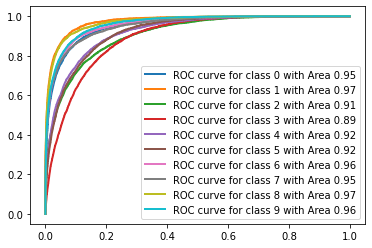

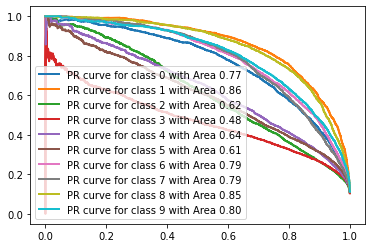

In [21]:
model1.load_state_dict(torch.load(model_path1))
print("LeNet测试集分类结果如下:")
test_loss, test_acc,prediction1,groundtruth1 = evaluate2(model1, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))
print("LeNet模型评测结果如下:")
model_merics(prediction1,groundtruth1)

# VGG11模型评测结果如下

VGG11测试集分类结果如下:
| Test Loss: 0.15998158456385136 | Test Acc: 0.9454399812221527 |
VGG11模型评测结果如下:


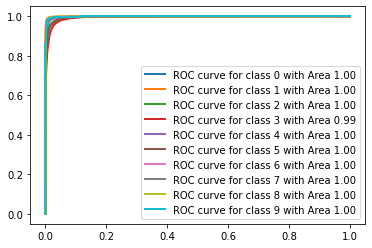

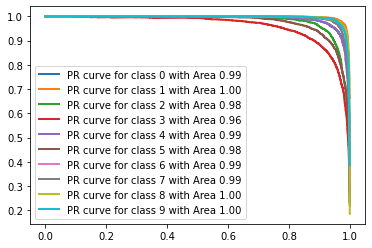

In [18]:
model2.load_state_dict(torch.load(model_path2))
print("VGG11测试集分类结果如下:")
test_loss, test_acc,prediction2,groundtruth2 = evaluate2(model2, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))
print("VGG11模型评测结果如下:")
model_merics(prediction2,groundtruth2)

# ResNet18模型评测结果如下

ResNet18测试集分类结果如下:
| Test Loss: 0.11742964841425418 | Test Acc: 0.9589199763536453 |
ResNet18模型评测结果如下:


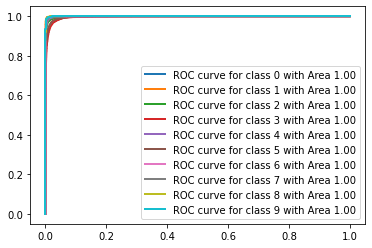

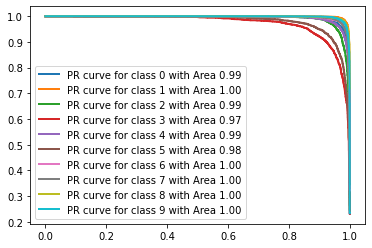

In [33]:
model3.load_state_dict(torch.load(model_path3))
print("ResNet18测试集分类结果如下:")
test_loss, test_acc,prediction3,groundtruth3 = evaluate2(model3, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))
print("ResNet18模型评测结果如下:")
model_merics(prediction3,groundtruth3)